## **IMPOR LIBRARY**

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


## **DATA LOADING**

In [72]:
df = pd.read_csv("car_price_prediction.csv")
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [74]:
df.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


## **EDA**

In [75]:
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [76]:
df.duplicated().sum()

np.int64(313)

In [77]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [78]:
df = df.drop(columns=["ID"])

In [79]:
df["Levy"] = df["Levy"].replace("-", np.nan).astype(float)
df["Levy"] = df["Levy"].fillna(df["Levy"].median())

In [80]:
df["Mileage"] = df["Mileage"].str.replace(" km", "", regex=False).astype(int)

In [81]:
df["Engine volume"] = (
    df["Engine volume"]
    .str.replace(" Turbo", "", regex=False)
    .astype(float)
)

In [82]:
df["Doors"] = df["Doors"].map({
    "02-Mar": 2,
    "04-May": 4
})
df["Doors"] = df["Doors"].fillna(df["Doors"].mode()[0])

In [83]:
df["Leather interior"] = df["Leather interior"].map({"Yes": 1, "No": 0})

## **MEMERIKSA OUTLIER**

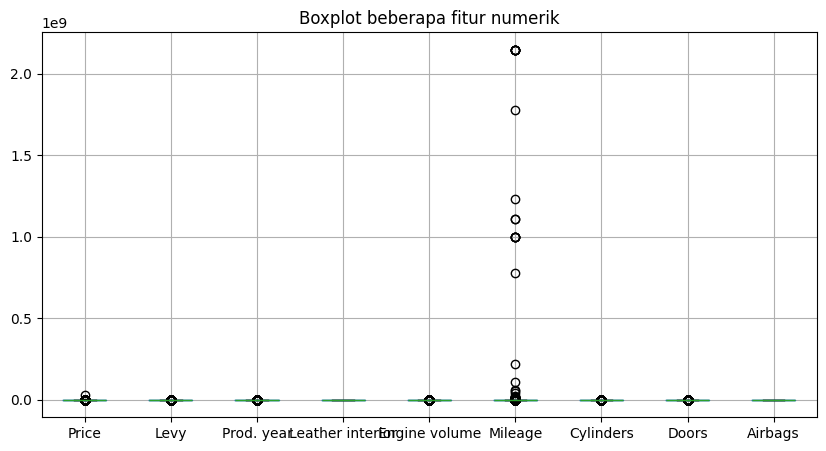

In [84]:
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols = [c for c in numeric_cols
                if c in df.columns]

plt.figure(figsize=(10, 5))
df[numeric_cols].boxplot()
plt.title("Boxplot beberapa fitur numerik")
plt.show()

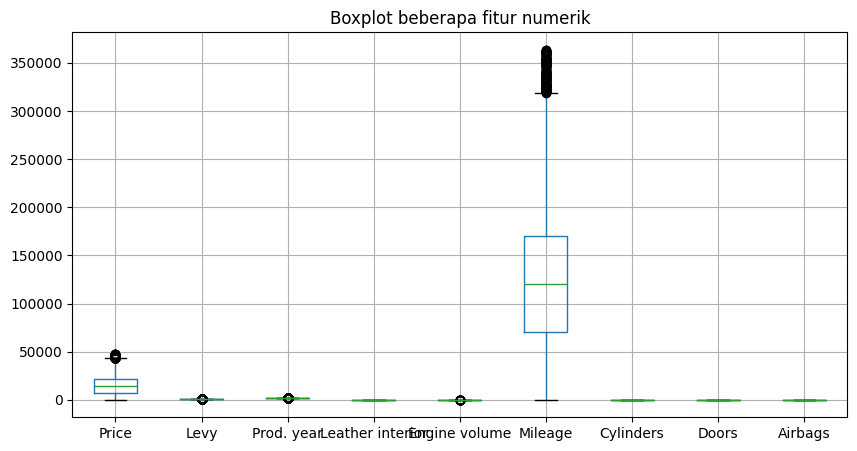

In [85]:
#Hapus outlier
numeric_cols = df.select_dtypes(include=np.number).columns

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
          (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

numeric_cols = [c for c in numeric_cols if c in df.columns]

plt.figure(figsize=(10, 5))
df[numeric_cols].boxplot()
plt.title("Boxplot beberapa fitur numerik")
plt.show()

## **DATA ENCODING** ##

In [86]:
cat_cols = df.select_dtypes(include="object").columns
cat_cols

Index(['Manufacturer', 'Model', 'Category', 'Fuel type', 'Gear box type',
       'Drive wheels', 'Wheel', 'Color'],
      dtype='object')

In [87]:
df_encoded = pd.get_dummies(
    df,
    columns=cat_cols,
    drop_first=True
)
df_encoded.head()

,Price,Levy,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Doors,Airbags,Manufacturer_ALFA ROMEO,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
2,8467,781.0,2006,0,1.3,200000,4.0,4.0,2,False,...,False,False,False,False,False,False,False,False,False,False
3,3607,862.0,2011,1,2.5,168966,4.0,4.0,0,False,...,False,False,False,False,False,False,False,False,True,False
5,39493,891.0,2016,1,2.0,160931,4.0,4.0,4,False,...,False,False,False,False,False,False,False,False,True,False
6,1803,761.0,2010,1,1.8,258909,4.0,4.0,12,False,...,False,False,False,False,False,False,False,False,True,False
7,549,751.0,2013,1,2.4,216118,4.0,4.0,12,False,...,False,True,False,False,False,False,False,False,False,False


## **PRE TRAIN**

In [88]:
X = df_encoded.drop("Price", axis=1)
y = df_encoded["Price"]

In [89]:
RANDOM_STATE = 86

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)


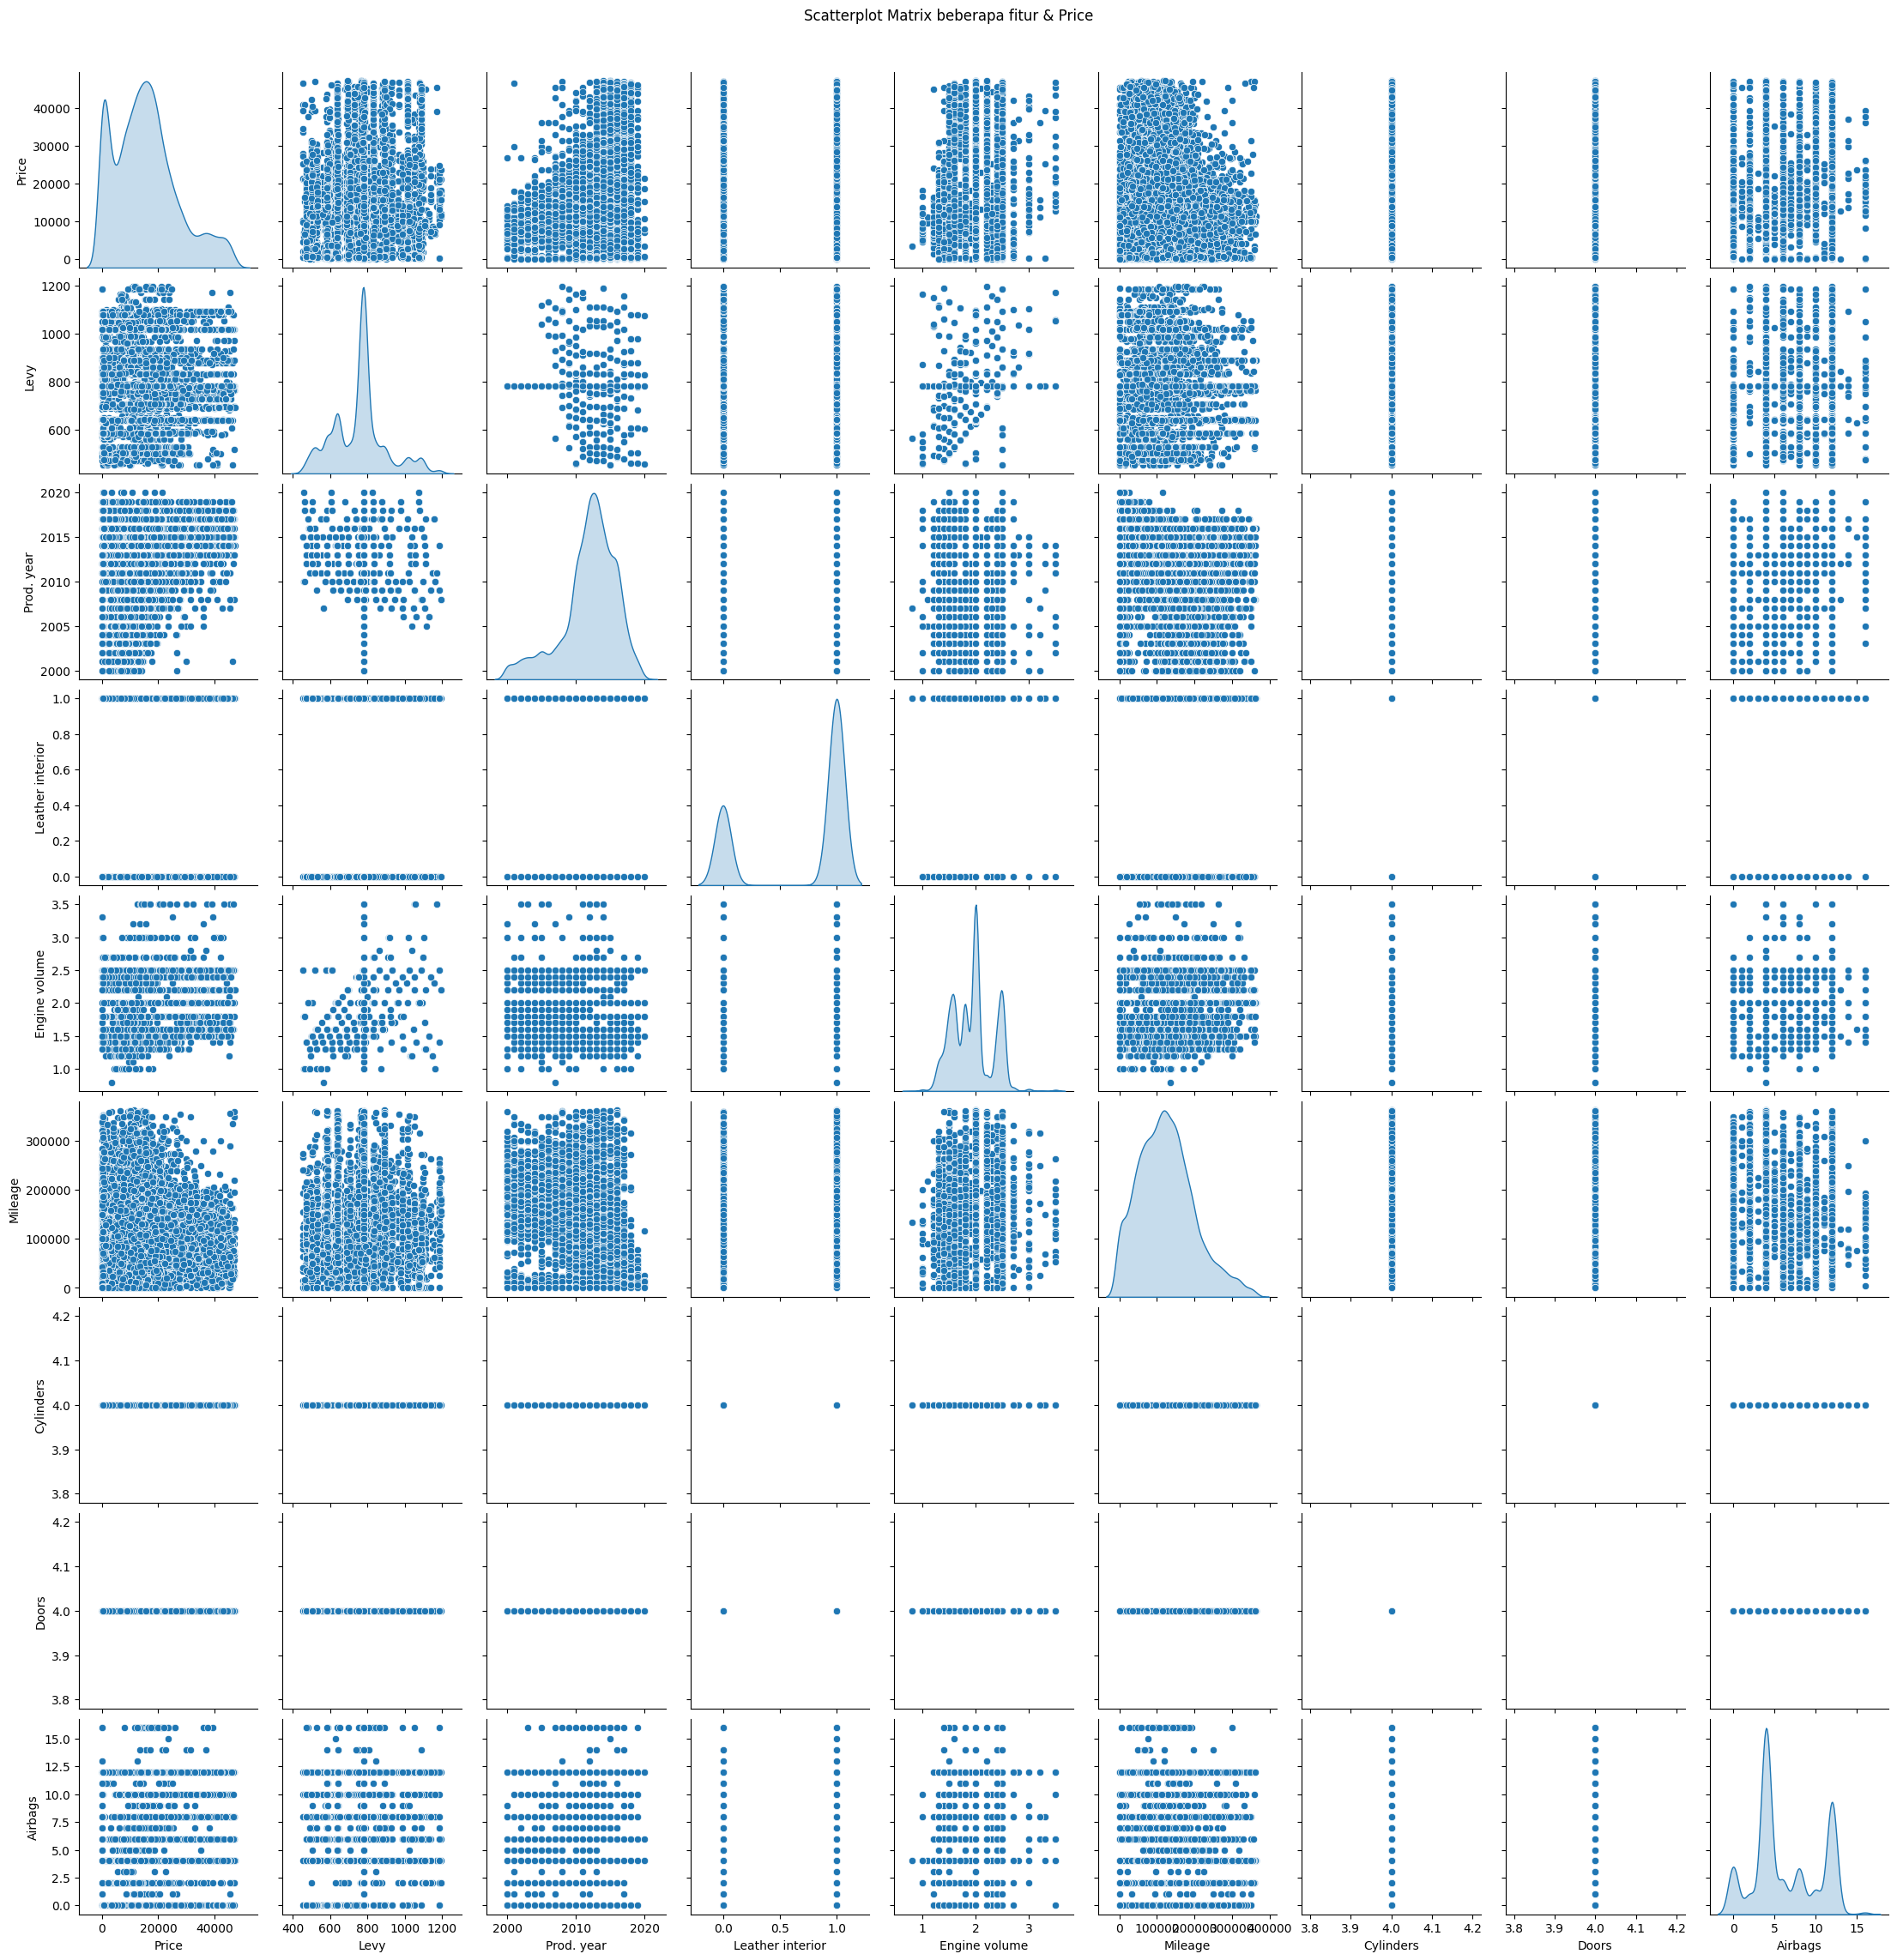

In [90]:
sns.pairplot(df[numeric_cols], diag_kind="kde")
plt.suptitle("Scatterplot Matrix beberapa fitur & Price", y=1.02)
plt.show()

## **PIPELINE 1 - DECISION TREE REGRESSION**

In [91]:
pipe_dt = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_regression)),
    ("model", DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [92]:
param_dt = [

    #Untuk SelectKBest
    {
        "scaler": [StandardScaler(), MinMaxScaler()],
        "selector": [SelectKBest(score_func=f_regression)],
        "selector__k": [5, 8, 10],
        "model__max_depth": [None, 5, 10],
        "model__min_samples_split": [2, 5, 10]
    },

    #Untuk SelectPercentile
    {
        "scaler": [StandardScaler(), MinMaxScaler()],
        "selector": [SelectPercentile(score_func=f_regression)],
        "selector__percentile": [20, 40, 60],
        "model__max_depth": [None, 5, 10],
        "model__min_samples_split": [2, 5, 10]
    }
]


In [93]:
gs_dt = GridSearchCV(
    pipe_dt,
    param_dt,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

gs_dt.fit(X_train, y_train)
print("Best parameters (Decision Tree):", gs_dt.best_params_)
print("Best CV score DT (R2):", gs_dt.best_score_)

Best parameters (Decision Tree): {'model__max_depth': 10, 'model__min_samples_split': 10, 'scaler': StandardScaler(), 'selector': SelectPercentile(score_func=<function f_regression at 0x00000124EE688C20>), 'selector__percentile': 60}
Best CV score DT (R2): 0.6540533461527953


## **PIPELINE 2 RANDOM FOREST REGRESSION**

In [94]:
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_regression)),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

param_rf = [
    # Untuk SelectKBest
    {
        "scaler": [StandardScaler(), MinMaxScaler()],
        "selector": [SelectKBest(score_func=f_regression)],
        "selector__k": [5, 8, 10],
        "model__n_estimators": [100, 500],
        "model__max_depth": [None, 10, 20]
    },
    # Untuk SelectPercentile
    {
        "scaler": [StandardScaler(), MinMaxScaler()],
        "selector": [SelectPercentile(score_func=f_regression)],
        "selector__percentile": [20, 40, 60],
        "model__n_estimators": [100, 500],
        "model__max_depth": [None, 10, 20]
    }
]

In [95]:
gs_rf = GridSearchCV(
    pipe_rf,
    param_rf,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

gs_rf.fit(X_train, y_train)
print("Best parameters (Random Forest):", gs_rf.best_params_)
print("Best CV score RF (R2):", gs_rf.best_score_)

Best parameters (Random Forest): {'model__max_depth': None, 'model__n_estimators': 500, 'scaler': MinMaxScaler(), 'selector': SelectPercentile(score_func=<function f_regression at 0x00000124EE688C20>), 'selector__percentile': 60}
Best CV score RF (R2): 0.7734461251618352


## **EVALUASI MODEL**

In [96]:
def regression_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

In [97]:
#DT
y_pred_dt = gs_dt.predict(X_test)
metrics_dt = regression_metrics(y_test, y_pred_dt)
metrics_dt

{'R2': 0.6719078428847016,
 'MSE': np.float64(40342040.32178318),
 'MAE': np.float64(4374.2092977514385),
 'RMSE': np.float64(6351.538421656849)}

In [98]:
# RF
y_pred_rf = gs_rf.predict(X_test)
metrics_rf = regression_metrics(y_test, y_pred_rf)
metrics_rf 

{'R2': 0.7881148236365519,
 'MSE': np.float64(26053290.647354484),
 'MAE': np.float64(3224.9963253509172),
 'RMSE': np.float64(5104.242416593718)}

In [99]:
# ganti best selector kalau R2 bagusan RF

best_selector = gs_rf.best_estimator_.named_steps["selector"]
selected_features = X.columns[best_selector.get_support()]
selected_features

Index(['Levy', 'Prod. year', 'Leather interior', 'Engine volume', 'Mileage',
       'Airbags', 'Manufacturer_AUDI', 'Manufacturer_BMW',
       'Manufacturer_BUICK', 'Manufacturer_CADILLAC',
       ...
       'Color_Carnelian red', 'Color_Golden', 'Color_Green', 'Color_Grey',
       'Color_Pink', 'Color_Red', 'Color_Silver', 'Color_Sky blue',
       'Color_White', 'Color_Yellow'],
      dtype='object', length=534)

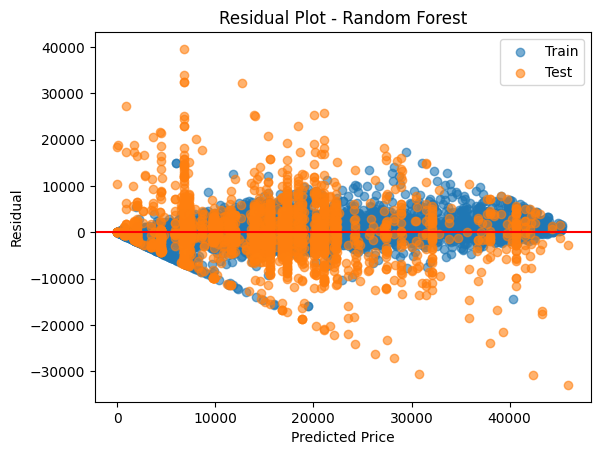

In [100]:
# ganti gs.dt kalau R2 bagusan RF, jadi gs.rf [pokoknya yang ada dt nya diganti rf kalau bagusan RF]

y_train_pred = gs_rf.predict(X_train)

plt.scatter(y_train_pred, y_train - y_train_pred, label="Train", alpha=0.6)
plt.scatter(y_pred_dt, y_test - y_pred_dt, label="Test", alpha=0.6)
plt.axhline(0, color="red")
plt.legend()
plt.title("Residual Plot - Random Forest")
plt.xlabel("Predicted Price")
plt.ylabel("Residual")
plt.show()


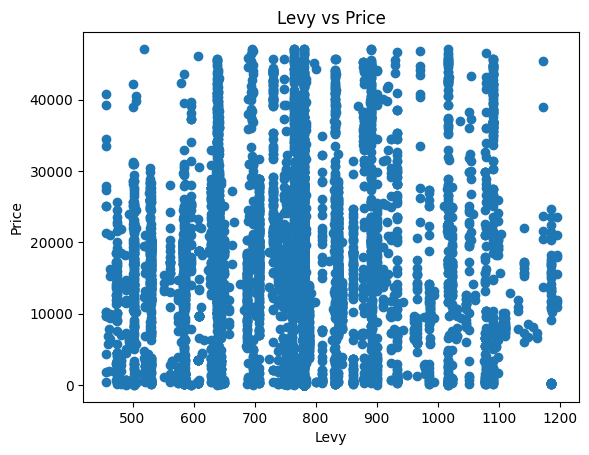

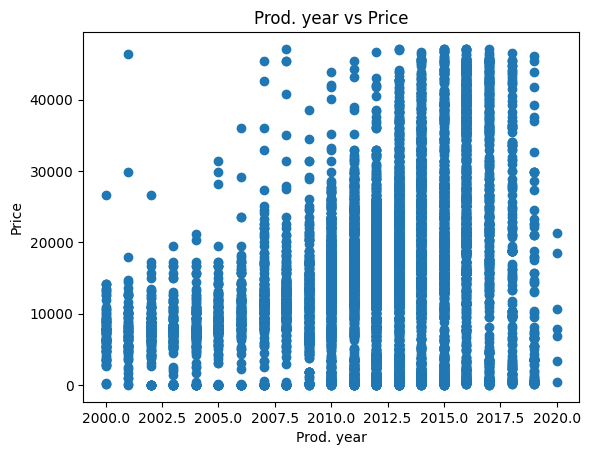

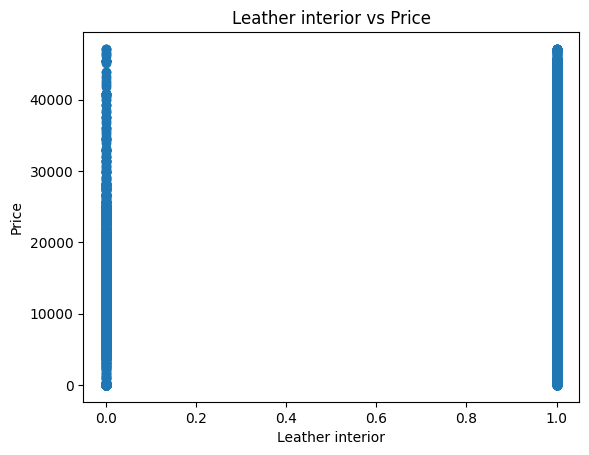

In [101]:
for feature in selected_features[:3]:
    plt.scatter(X_train[feature], y_train)
    plt.xlabel(feature)
    plt.ylabel("Price")
    plt.title(f"{feature} vs Price")
    plt.show()

In [102]:
# ini juga kalau R2 RF bagus ganti aja DT ke RF
comparison = pd.DataFrame({
    "Actual": y_test.iloc[:20].values,
    "Predicted": y_pred_rf[:20]
})

comparison

,Actual,Predicted
0,42171,41968.258000
1,41281,42875.066000
2,19757,20603.652800
3,3136,1772.646000
4,2666,2592.547333
5,13172,3878.528000
6,20385,20604.684000
7,28830,19149.786000
8,23834,21411.036000
9,10192,12286.236000


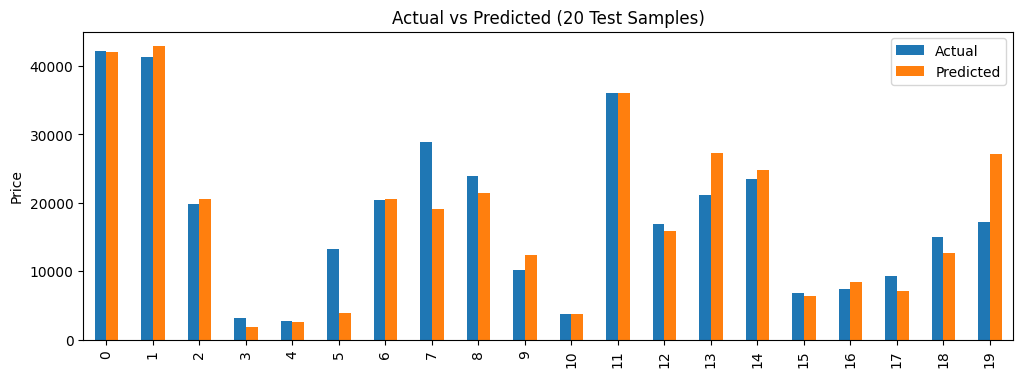

In [103]:
comparison.plot(kind="bar", figsize=(12,4))
plt.title("Actual vs Predicted (20 Test Samples)")
plt.ylabel("Price")
plt.show()

## **Residual Plot**

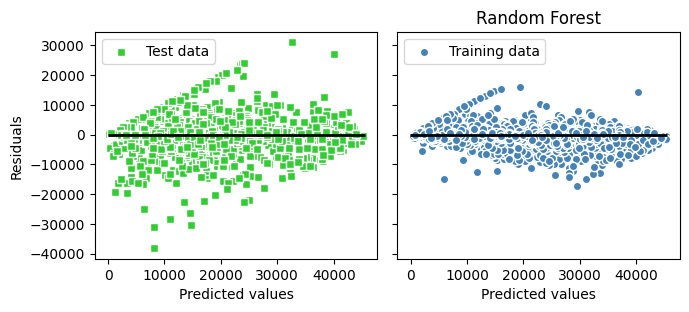

In [104]:
if metrics_rf["R2"] > metrics_dt["R2"]:
    y_train_pred = gs_rf.predict(X_train)
    y_test_pred = gs_rf.predict(X_test)
    model_name = "Random Forest"
else:
    y_train_pred = gs_dt.predict(X_train)
    y_test_pred = gs_dt.predict(X_test)
    model_name = "Decision Tree"

x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')

ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()
plt.title(model_name)
plt.show()     

## **Model Deployment**

In [105]:
import pickle

best_model = gs_rf.best_estimator_

with open("BestModel_RandomForest_CatBoost.pkl", "wb") as f:   
    pickle.dump(best_model, f)

with open("columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

print("✅") 

✅
